In [15]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import pickle as pkl

In [16]:
files = ["Monday-WorkingHours.pcap_ISCX.csv", #0
         "Tuesday-WorkingHours.pcap_ISCX.csv", #1
         "Wednesday-workingHours.pcap_ISCX.csv", #2
         "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", #3
         "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv", #4
         "Friday-WorkingHours-Morning.pcap_ISCX.csv", #5
         "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", #6
         "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"] #7

def dataset_file_to_df(index: int, dataset_files: list):
    read_file = f"datasets/CSVs/{dataset_files[index]}"

    df_read = pd.read_csv(read_file)
    df_read.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    return df_read

df0 = dataset_file_to_df(0, files)
df1 = dataset_file_to_df(1, files)
df2 = dataset_file_to_df(2, files)
df3 = dataset_file_to_df(3, files)
df4 = dataset_file_to_df(4, files)
df5 = dataset_file_to_df(5, files)
df6 = dataset_file_to_df(6, files)
df7 = dataset_file_to_df(7, files)

df1 = df1[df1["Label"] != "BENIGN"]
df2 = df2[df2["Label"] != "BENIGN"]
df3 = df3[df3["Label"] != "BENIGN"]
df4 = df4[df4["Label"] != "BENIGN"]
df5 = df5[df5["Label"] != "BENIGN"]
df6 = df6[df6["Label"] != "BENIGN"]
df7 = df7[df7["Label"] != "BENIGN"]

df = pd.concat([df0,df1,df2,df3,df4,df5,df6,df7], axis=0, ignore_index=True)


In [17]:
def normalize(df):
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
    df_norm = df.copy()
    for col in numeric_columns:
        if df[col].skew() > 0 or col == "Source Port":
            df_norm[col] = np.log1p(df[col].clip(lower=-0.99))  # Ensures log1p always gets valid input
        elif df[col].skew() < 0:
            df_norm[col] = df[col] ** 2  # Can cause overflow
    return df_norm

df_norm = normalize(df)
df_norm = df_norm[df_norm['Label'] != "Heartbleed"]
df_norm = df_norm[df_norm['Label'] != "Infiltration"]
df_norm['Label'] = df_norm['Label'].apply(lambda x: 'DoS' if x.startswith('DoS') else x)
df_norm['Label'] = df_norm['Label'].apply(lambda x: 'WebAttack' if x.startswith('Web Attack') else x)


In [18]:
X = df_norm.drop(["Flow ID", "Src IP", "Timestamp", "Dst IP", "Label"], axis=1)
y = df_norm["Label"]

In [19]:
y.value_counts()

Label
BENIGN         529918
DoS            252661
PortScan       158930
DDoS           128027
FTP-Patator      7938
SSH-Patator      5897
WebAttack        2180
Bot              1966
Name: count, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

Label
BENIGN         423934
DoS            202129
PortScan       127144
DDoS           102421
FTP-Patator      6350
SSH-Patator      4718
WebAttack        1744
Bot              1573
Name: count, dtype: int64
Label
BENIGN         105984
DoS             50532
PortScan        31786
DDoS            25606
FTP-Patator      1588
SSH-Patator      1179
WebAttack         436
Bot               393
Name: count, dtype: int64


In [9]:
import pandas as pd
from imblearn.over_sampling import SMOTE

import pandas as pd
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Grupowanie klas wg ilości
class_counts = y_train.value_counts()

# Progi
threshold_medium = 20000
threshold_minor = 100

# Podział klas
medium_classes = class_counts[(class_counts >= threshold_medium)].index.tolist()
minor_classes = class_counts[(class_counts < threshold_medium) & (class_counts >= threshold_minor) ].index.tolist()

print(f"Medium classes: {medium_classes}")
print(f"Minor classes: {minor_classes}")

df_train = pd.DataFrame(X_train, columns=X.columns)

df_train["Label"] = y_train.reset_index(drop=True)

# SMOTE dla średnich
df_medium = df_train[df_train['Label'].isin(medium_classes)]
X_medium = df_medium.drop('Label', axis=1)
y_medium = df_medium['Label']
# Oversampling małych klas
df_minor = df_train[df_train['Label'].isin(minor_classes)]
X_minor = df_minor.drop('Label', axis=1)
y_minor = df_minor['Label']

sampling_strategy = {cls: 20000 for cls in minor_classes}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_minor_res, y_minor_res = smote.fit_resample(X_minor, y_minor)

# Klasy z obserwacjami poniżej 100 uznajemy za niereprezentatywne

# Finalne scalanie
X_train = pd.concat([
    pd.DataFrame(X_medium),
    pd.DataFrame(X_minor_res)])
y_train = pd.concat([
    pd.Series(y_medium),
    pd.Series(y_minor_res)])

y_train = y_train.apply(lambda x: 0 if x == 'BENIGN' else 1)
y_test = y_test.apply(lambda x: 0 if x == 'BENIGN' else 1)

print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())

Medium classes: ['BENIGN', 'DoS', 'PortScan', 'DDoS']
Minor classes: ['FTP-Patator', 'SSH-Patator', 'WebAttack', 'Bot']
Train class distribution:
 Label
1    511694
0    423934
Name: count, dtype: int64
Test class distribution:
 Label
1    111520
0    105984
Name: count, dtype: int64


In [10]:
print(pd.Series(y_train).value_counts())

Label
1    511694
0    423934
Name: count, dtype: int64


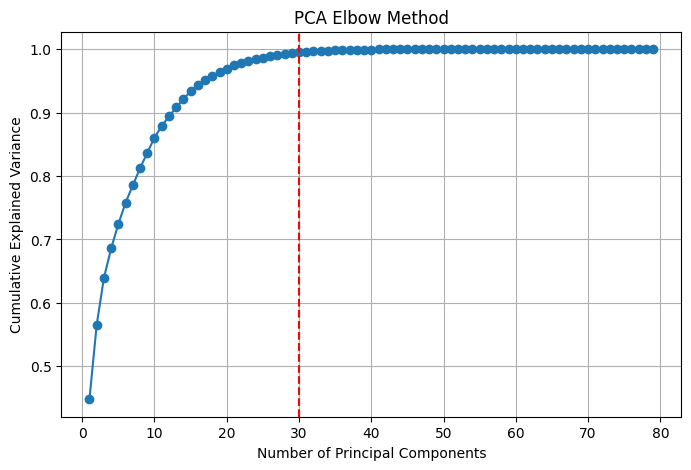

Optimal number of components: 30


In [11]:
pca = PCA()

pca.fit(X_train)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')

# Find the elbow point (where variance gain is <1%)
elbow_point = np.argmax(np.diff(cumulative_variance) < 0.001) + 1

plt.axvline(x=elbow_point, color='r', linestyle="--")  # Mark elbow
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Elbow Method")
plt.grid()
plt.show()

print(f"Optimal number of components: {elbow_point}")

In [12]:
pca = PCA(n_components=elbow_point)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [13]:
import pickle as pkl

def save_model(model, file):
  with open(file, "wb") as f:
    pkl.dump(model,f)

### SVM

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


svc = SVC(C=0.01, gamma='scale', kernel='poly')
svc.fit(X_train_pca, y_train)


SVC(C=0.01, kernel='poly')

In [15]:
y_pred = svc.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    105984
           1       0.98      0.99      0.99    111520

    accuracy                           0.98    217504
   macro avg       0.99      0.98      0.98    217504
weighted avg       0.98      0.98      0.98    217504



In [16]:
save_model(svc, "svc_bin.pkl")

### Binary DecisionTreeClassifier

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

tree = DecisionTreeClassifier(criterion= 'gini', max_depth=7, max_features= 'log2',
min_samples_leaf= 9, min_samples_split= 10, splitter= 'best')

tree.fit(X_train_pca, y_train)



DecisionTreeClassifier(max_depth=7, max_features='log2', min_samples_leaf=9,
                       min_samples_split=10)

In [18]:
from sklearn.metrics import classification_report
y_pred_dt = tree.predict(X_test_pca)

print(classification_report(y_test, y_pred_dt))
save_model(tree, "tree_bin.pkl")

              precision    recall  f1-score   support

           0       0.95      0.90      0.92    105984
           1       0.91      0.96      0.93    111520

    accuracy                           0.93    217504
   macro avg       0.93      0.93      0.93    217504
weighted avg       0.93      0.93      0.93    217504



### KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder


knn = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 29, p= 3, weights= 'uniform')

knn.fit(X_train_pca, y_train)




KNeighborsClassifier(metric='manhattan', n_neighbors=29, p=3)

In [20]:
y_pred = knn.predict(X_test_pca)
print(classification_report(y_test, y_pred))
save_model(knn, "knn_bin.pkl")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105984
           1       1.00      1.00      1.00    111520

    accuracy                           1.00    217504
   macro avg       1.00      1.00      1.00    217504
weighted avg       1.00      1.00      1.00    217504

